# Data Processing

In [1]:
# Read data
import pandas as pd
df=pd.read_csv('titanic.csv')

# Drop the unused variables
df=df.drop(['Name'], axis=1)

df=df.head(20)

In [2]:
from patsy import dmatrices
# Create matrices
y, X= dmatrices('Survived ~ Age + Fare + Q("Siblings/Spouses Aboard") + Q("Parents/Children Aboard") + C(Pclass) + C(Sex)', df, return_type = 'dataframe')

In [3]:
#Remove intercept
X=X.iloc[:,1:]

In [4]:
X.head()

,C(Pclass)[T.2],C(Pclass)[T.3],C(Sex)[T.male],Age,Fare,"Q(""Siblings/Spouses Aboard"")","Q(""Parents/Children Aboard"")"
0,0.0,1.0,1.0,22.0,7.2500,1.0,0.0
1,0.0,0.0,0.0,38.0,71.2833,1.0,0.0
2,0.0,1.0,0.0,26.0,7.9250,0.0,0.0
3,0.0,0.0,0.0,35.0,53.1000,1.0,0.0
4,0.0,1.0,1.0,35.0,8.0500,0.0,0.0


# Step 1: Gini Index

In [5]:
# The Gini index is the name of the cost function used to evaluate splits in the dataset.Could entropy too but Gini is more efficient
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

In [6]:
print(gini_index([[[1, 1], [1, 0]], [[1, 1], [1, 0]]], [0, 1]))
print(gini_index([[[1, 0], [1, 0]], [[1, 1], [1, 1]]], [0, 1]))

0.5
0.0


# Step 2: Split Dataset

In [7]:
# Split based on a threshold
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [8]:
# We would test every single split and its gini in order to find best split
# So this greedy algorithm need many computations
# Use this we could find the split with minimum gini
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups=999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups=test_split(index, row[index], dataset)
            gini=gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
                print(f'index: {b_index}, value: {b_value}, b_score: {b_score}')
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [10]:
import numpy as np
dataset=np.array(pd.merge(X, y, right_index=True, left_index=True))

In [11]:
get_split(dataset)

index: 0, value: 0.0, b_score: 0.5
index: 0, value: 1.0, b_score: 0.4117647058823529
index: 1, value: 1.0, b_score: 0.36263736263736274
index: 2, value: 1.0, b_score: 0.2525252525252525


{'index': 2,
 'value': 1.0,
 'groups': ([array([ 0.    ,  0.    ,  0.    , 38.    , 71.2833,  1.    ,  0.    ,
           1.    ]),
   array([ 0.   ,  1.   ,  0.   , 26.   ,  7.925,  0.   ,  0.   ,  1.   ]),
   array([ 0. ,  0. ,  0. , 35. , 53.1,  1. ,  0. ,  1. ]),
   array([ 0.    ,  1.    ,  0.    , 27.    , 11.1333,  0.    ,  2.    ,
           1.    ]),
   array([ 1.    ,  0.    ,  0.    , 14.    , 30.0708,  1.    ,  0.    ,
           1.    ]),
   array([ 0. ,  1. ,  0. ,  4. , 16.7,  1. ,  1. ,  1. ]),
   array([ 0.  ,  0.  ,  0.  , 58.  , 26.55,  0.  ,  0.  ,  1.  ]),
   array([ 0.    ,  1.    ,  0.    , 14.    ,  7.8542,  0.    ,  0.    ,
           0.    ]),
   array([ 1.,  0.,  0., 55., 16.,  0.,  0.,  1.]),
   array([ 0.,  1.,  0., 31., 18.,  1.,  0.,  0.]),
   array([ 0.   ,  1.   ,  0.   , 22.   ,  7.225,  0.   ,  0.   ,  1.   ])],
  [array([ 0.  ,  1.  ,  1.  , 22.  ,  7.25,  1.  ,  0.  ,  0.  ]),
   array([ 0.  ,  1.  ,  1.  , 35.  ,  8.05,  0.  ,  0.  ,  0.  ]),
   ar

In [12]:
# index 2 (Sex: male) is the split with smallist gini, which split the group the most
# Let's check
# if column=1 (male), there is only 11% survied; when the column=0 (female), there is 82% survived
print(sum(dataset[dataset[:,2]==1][:,-1])/len(dataset[dataset[:,2]==1][:,-1]))
print(sum(dataset[dataset[:,2]==0][:,-1])/len(dataset[dataset[:,2]==0][:,-1]))

0.1111111111111111
0.8181818181818182


# Step 3: Build a Tree

In [13]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [14]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [15]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [16]:
tree=build_tree(dataset, 3, 5)

index: 0, value: 0.0, b_score: 0.5
index: 0, value: 1.0, b_score: 0.4117647058823529
index: 1, value: 1.0, b_score: 0.36263736263736274
index: 2, value: 1.0, b_score: 0.2525252525252525
index: 0, value: 0.0, b_score: 0.2975206611570247
index: 0, value: 1.0, b_score: 0.2828282828282828
index: 1, value: 1.0, b_score: 0.2424242424242424
index: 0, value: 0.0, b_score: 0.4444444444444444
index: 3, value: 27.0, b_score: 0.41666666666666663
index: 3, value: 14.0, b_score: 0.4
index: 3, value: 31.0, b_score: 0.26666666666666655
index: 0, value: 0.0, b_score: 0.19753086419753085
index: 0, value: 1.0, b_score: 0.0
index: 0, value: 0.0, b_score: 0.0


In [17]:
tree

{'index': 2,
 'value': 1.0,
 'left': {'index': 1,
  'value': 1.0,
  'left': 1.0,
  'right': {'index': 3, 'value': 31.0, 'left': 1.0, 'right': 0.0}},
 'right': {'index': 0,
  'value': 1.0,
  'left': {'index': 0, 'value': 0.0, 'left': 0.0, 'right': 0.0},
  'right': 1.0}}

In [18]:
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [19]:
print_tree(tree, 3)

   [X3 < 1.000]
    [X2 < 1.000]
     [1.0]
     [X4 < 31.000]
      [1.0]
      [0.0]
    [X1 < 1.000]
     [X1 < 0.000]
      [0.0]
      [0.0]
     [1.0]


# Let's Use Sklearn

In [23]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=5)
clf = clf.fit(X, y)

[Text(167.4, 190.26, 'X[2] <= 0.5\ngini = 0.5\nsamples = 20\nvalue = [10, 10]'),
 Text(83.7, 135.9, 'X[1] <= 0.5\ngini = 0.298\nsamples = 11\nvalue = [2, 9]'),
 Text(41.85, 81.53999999999999, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(125.55000000000001, 81.53999999999999, 'X[4] <= 17.35\ngini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(83.7, 27.180000000000007, 'gini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(167.4, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(251.10000000000002, 135.9, 'X[0] <= 0.5\ngini = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(209.25, 81.53999999999999, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(292.95, 81.53999999999999, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

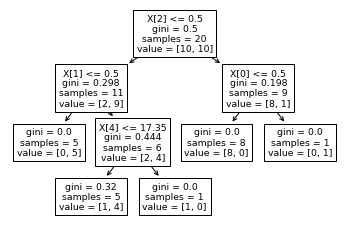

In [24]:
# Plot it
tree.plot_tree(clf) 

In [26]:
clf.predict(X)

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 0., 1.])